In [ ]:
import http.server as SimpleHTTPServer
import os
import re
import sys

def copy_byte_range(infile, outfile, start=None, stop=None, bufsize=16*1024):
    if start is not None: infile.seek(start)
    while 1:
        to_read = min(bufsize, stop + 1 - infile.tell() if stop else bufsize)
        if buf := infile.read(to_read):
            outfile.write(buf)
        else:
            break


BYTE_RANGE_RE = re.compile(r'bytes=(\d+)-(\d+)?$')
def parse_byte_range(byte_range):
    if byte_range.strip() == '':
        return None, None

    m = BYTE_RANGE_RE.match(byte_range)
    if not m:
        raise ValueError(f'Invalid byte range {byte_range}')

    first, last = [x and int(x) for x in m.groups()]
    if last and last < first:
        raise ValueError(f'Invalid byte range {byte_range}')
    return first, last


class RangeRequestHandler(SimpleHTTPServer.SimpleHTTPRequestHandler):
    def send_head(self):
        if 'Range' not in self.headers:
            self.range = None
            return SimpleHTTPServer.SimpleHTTPRequestHandler.send_head(self)
        try:
            self.range = parse_byte_range(self.headers['Range'])
        except ValueError as e:
            self.send_error(400, 'Invalid byte range')
            return None
        first, last = self.range

        # Mirroring SimpleHTTPServer.py here
        path = self.translate_path(self.path)
        f = None
        ctype = self.guess_type(path)
        try:
            f = open(path, 'rb')
        except IOError:
            self.send_error(404, 'File not found')
            return None

        fs = os.fstat(f.fileno())
        file_len = fs[6]
        if first >= file_len:
            self.send_error(416, 'Requested Range Not Satisfiable')
            return None

        self.send_response(206)
        self.send_header('Content-type', ctype)

        if last is None or last >= file_len:
            last = file_len - 1
        response_length = last - first + 1

        self.send_header('Content-Range', f'bytes {first}-{last}/{file_len}')
        self.send_header('Content-Length', str(response_length))
        self.send_header('Last-Modified', self.date_time_string(fs.st_mtime))
        self.end_headers()
        return f

    def end_headers(self):
        self.send_header('Accept-Ranges', 'bytes')
        return SimpleHTTPServer.SimpleHTTPRequestHandler.end_headers(self)

    def copyfile(self, source, outputfile):
        if not self.range:
            return SimpleHTTPServer.SimpleHTTPRequestHandler.copyfile(self, source, outputfile)

        start, stop = self.range  # set in send_head()
        copy_byte_range(source, outputfile, start, stop)


def main():
    port = 8000

    # Manually parse command line arguments
    for i in range(1, len(sys.argv)):
        arg = sys.argv[i]
        if arg.startswith('--port='):
            port = int(arg[len('--port='):])
        elif arg == '--port':
            if i + 1 < len(sys.argv):
                port = int(sys.argv[i+1])

    SimpleHTTPServer.test(HandlerClass=RangeRequestHandler, port=port)


if __name__ == '__main__':
    main()


In [ ]:

url = "https://passport.bilibili.com/x/passport-login/web/qrcode/generate"
response = requests.get(f"{url}", timeout = 5)
response = response.json()
print(response)

In [2]:
import requests

url = "https://api.bilibili.com/x/space/wbi/arc/search?mid=23947287"
response = requests.get(f"{url}", timeout = 5)
response = response.json()
print(response)

{'code': -401, 'message': '非法访问', 'ttl': 1, 'data': {'ga_data': {'decisions': ['verify_captcha_level2'], 'risk_level': 1, 'grisk_id': '31dfe0498433e8c061f4fc380d6541e0', 'decision_ctx': {'buvid': '', 'decision_type': '4', 'ip': '20.212.210.2', 'mid': '0', 'origin_scene': 'anti_crawler', 'scene': 'crawler_main_space_wbi_acc_search', 'ua': 'python-requests/2.31.0', 'v_voucher': 'voucher_620dfdfc-2197-428d-96e1-34528b4eaf63'}}}}


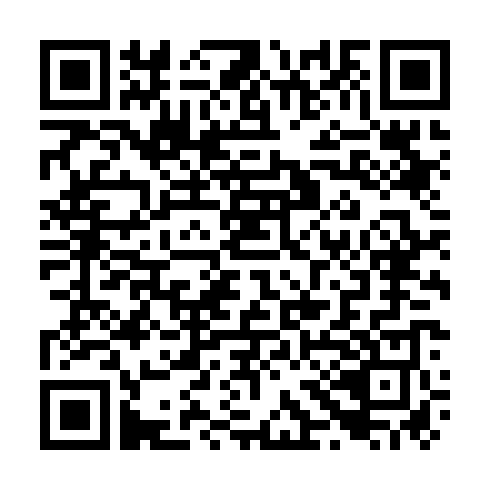

█▀▀▀▀▀█ ▄█ ▄█  ▄▀▀▀▀██ ▀▄ ▄▄█ █▀▀ █▀▀▀▀▀█
█ ███ █ ▄▀▀█▀ ▀ ▀ ▄██▀▄ ▀▄▀ ▀▄█▀▄ █ ███ █
█ ▀▀▀ █ ▄█▄█▀ ▀▀▀▄▀▀▄█ ▀█▀█▄▀▀▄▀▄ █ ▀▀▀ █
▀▀▀▀▀▀▀ ▀ ▀ █ █ █ ▀ █▄█ ▀ █▄▀ ▀ █ ▀▀▀▀▀▀▀
▀▀▀██▄▀▀█▄ ████ ▄█▄█▄▄█▄ ▀  ▄▀▄▄▄▀▄█▄█ █▄
▄▄█▀  ▀█ ▀██▄█▀▀██▄ ▄▄ ▄   ▀▀▀ ▄▄ ▀▀█▄  ▄
█ ▀▄ █▀ ▄  ▀▄ ▀▄▀▄▄█▄▄▄█▀█▄▀▀█▄█▄▀▄▀▄██▀▄
  ▄██▀▀▀▀▀█ ▄▀▀█▀ ▀▄█▄▄▄▄▀██  ▄ ▀▀▄▀▀█▀▄ 
▀█▄█▄█▀  ▄▀▄█▀▀▀▀▀▄█▄▄█▄█▀▀▀▄▀▄█  ▄▄▄ ▀▄▄
▀ ▀▄▄█▀▀█▀▀ ▄ ▄▀▄ ▀▄██▄ █ ▄▀▄ ▄ ▄▀▄ █▄ ▄▄
▀▀▀▄██▀▄▄▄▀ ▀▄▄▄▄▄▀█▄▄▄▄▀█▄ ▀█▀▄▀▄▄█▄█▀▀▄
█▀▀ █ ▀▄▄▀▀█▀   ▄▀▄▄ ▄▄ ▄  █▀ ▀▄▄▀▄██▄ ▄ 
 ▄▄▀█ ▀▀ █▀█▄█▀ ▄██▄  █▄ ▀▄▀ ▀▄▄█ ▄█▄ ▀▀█
   █▀█▀▄ ▄█  █▀█▀█▄ ▄█▄ █▀██▀ █▄ ▄▄█ ▀▀  
▄▄▀█▀ ▀▄██▄▀▄▄▀█▀▄▄▄█▄▄▄▀▀▄ ▄▀▀▄▄▀▄▄▄█▀█▄
█ ▀▄█▀▀▄ ▀  ▄ ▄█▀▀ ▄▄█ ▄█ █▀▀▀█▄▀█ ▀ █ ▄ 
▀ ▀   ▀▀▄ █▄▄▀▀▀▄▀ ▄█▄▀▄ ▀ ▀▄▀▄▄█▀▀▀█▀▄ ▄
█▀▀▀▀▀█ ▀█    ▄▀▀ ▀▄ █  ▄ ▀█▄▀▀██ ▀ █ ▀▄▄
█ ███ █ █▄  ▀ ▄█▄ ▀▄▄  ▄▀█▄ ▀█▄▄█▀▀▀▀▄█ ▄
█ ▀▀▀ █ ████▀ ▀ ▄▀▀▄▄▄█ ▄ █▀▀ ▀██▀▀▄▀█▀▄ 
▀▀▀▀▀▀▀ ▀▀ ▀▀▀▀  ▀  ▀ ▀▀▀▀▀▀ ▀   ▀ ▀  ▀  
扫描成功
扫描成功
扫描成功
扫描成功
扫描成功
扫描成功
扫描成功
扫描成功
扫描成功
扫描成功
扫描成功
扫描成功
扫描成功
扫描成功
扫描成功
扫描成功
扫描成功
扫描成功
存储cookie: <RequestsCookieJar

In [1]:
import qrcode
import requests
import math

# 申请二维码并获取token和URL
def request_qr_code():
    # 实际申请二维码的API请求
    response = requests.get('https://passport.bilibili.com/x/passport-login/web/qrcode/generate')
    data = response.json()
    return data['data']['qrcode_key'], data['data']['url']

#网址二维码模块
def qr_code(data):
    # 创建一个QRCode对象
    qr = qrcode.QRCode(version=1, error_correction=qrcode.constants.ERROR_CORRECT_L, box_size=1, border=0)
    # 设置二维码的数据
    qr.add_data(data)
    # 获取QR Code矩阵
    qr.make(fit=True)
    matrix = qr.make_image(fill_color="black", back_color="white").modules
    # 获取图像的宽度和高度
    width, height = len(matrix), len(matrix)
    height_double = math.ceil(height/2)
    # 转换图像为ASCII字符
    fonts = ["▀", "▄", "█", " "]
    ascii_art = ""
    for y in range(height_double):
        if (y+1)*2-1 >= height:
            for x in range(width):
                ascii_art += fonts[0] if matrix[(y+1)*2-2][x] is True else fonts[3]
        else:
            for x in range(width):
                if matrix[(y+1)*2-2][x] is True and matrix[(y+1)*2-1][x] is True:
                    ascii_art += fonts[2]
                elif matrix[(y+1)*2-2][x] is True and matrix[(y+1)*2-1][x] is False:
                    ascii_art += fonts[0]
                elif matrix[(y+1)*2-2][x] is False and matrix[(y+1)*2-1][x] is True:
                    ascii_art += fonts[1]
                else:
                    ascii_art += " "
            ascii_art += "\n"
    print(ascii_art)

# 生成二维码
def generate_qr_code(url):
    qr = qrcode.QRCode(version=1, error_correction=qrcode.constants.ERROR_CORRECT_L, box_size=10, border=4)
    qr.add_data(url)
    qr.make(fit=True)
    img = qr.make_image(fill_color="black", back_color="white")
    img.show()

# 扫码登录并返回状态和cookie
def scan_login(token):
    # 实际扫码登录的API请求
    response = requests.get(f'https://passport.bilibili.com/x/passport-login/web/qrcode/poll?qrcode_key={token}')
    data = response.json()
    cookies = response.cookies
    return data['data']['code'], cookies

# 主函数
def bilibili():
    token, url = request_qr_code()
    generate_qr_code(url)
    qr_code(url)

    while True:
        status, cookie = scan_login(token)
        if status == 86101:
            continue
        elif status == 86038:
            print('二维码失效或超时')
            break
        elif status == 86090:
            print('扫描成功')
        elif status == 0:
            print('扫描成功')
            if cookie:
                # 存储cookie的操作
                print('存储cookie:', cookie)
            # SSO登录页面跳转
            print('SSO登录页面跳转')
            break

bilibili()


In [ ]:
print(requests.get("https://api.bilibili.com/x/web-interface/nav"))